In [1]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [91]:
#for u in GF(q), we can factor as u=aa^* using gen. z and modular arithmetic
def conj_square_root(u):
    if u == 0:
        return 0  # Special case for 0
    z = F.multiplicative_generator()
    k = u.log(z)  # Compute discrete log of u to the base z
    if k % (q+1) != 0:
        raise ValueError("Unable to factor: u is not in base field GF(q)")
    return z ** ((k//(q+1))%(q-1))

In [110]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft():
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_square_root(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [138]:
#parameters and define the symmetric group algebra
n = 5; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n)
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(G.cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [139]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft();

In [140]:
U*U.H == 1

True

In [141]:
z = F.multiplicative_generator()
log_U = matrix([[U[(i,j)].log(z) if U[(i,j)] != 0 else -1 for j in range(U.nrows())] for i in range(U.nrows())])

In [142]:
U

120 x 120 dense matrix over Finite Field in z2 of size 7^2 (use the '.str()' method to see the entries)

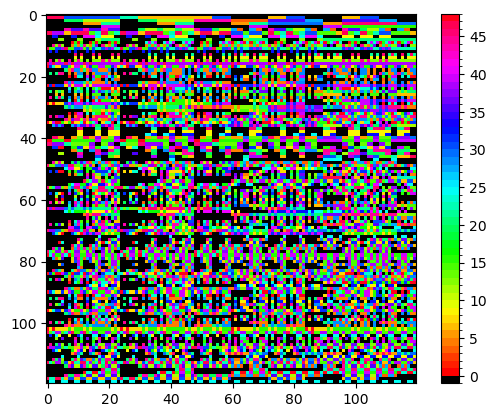

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

# Create a custom colormap with black at the start, and then use the HSV colormap
cmap = plt.cm.hsv  # Get the HSV colormap
new_colors = np.vstack(([0, 0, 0, 1], cmap(np.linspace(0, 1, F.order()))))  # Add black as the first color
custom_cmap = ListedColormap(new_colors)

# Use BoundaryNorm to define the color mapping: -1 gets black, others use the HSV colors
norm = BoundaryNorm([-1]+[i for i in range(F.order())], custom_cmap.N)  # Maps -1 to black, 0 to the first color of HSV

# Plotting the data
plt.imshow(log_U, cmap=custom_cmap, norm=norm, interpolation="nearest")
plt.colorbar()
plt.show()

In [123]:
to_root_of_unity = lambda a, F: 0 if a == 0 else exp(2*pi*I*a.log(F.multiplicative_generator())/(F.order()-1))

In [124]:
U_complex = matrix(CC,[[to_root_of_unity(U[(i,j)],F) for j in range(U.nrows())] for i in range(U.nrows())])

In [125]:
gram = U_complex*U_complex.H

In [126]:
def round_complex(z, digits):
    if z.imag_part():
        return round(z.real_part(), digits) + round(z.imag_part(), digits) * I
    return round(z, digits)

In [127]:
gram_rounded = gram.apply_map(lambda u:round_complex(u,2))

In [128]:
print(gram_rounded)

[          6.0           0.0           0.0           0.0 4.24 - 1.41*I           0.0]
[          0.0           6.0           0.0           0.0           0.0 4.24 + 1.41*I]
[          0.0           0.0           4.0           0.0           0.0           0.0]
[          0.0           0.0           0.0           4.0           0.0           0.0]
[4.24 + 1.41*I           0.0           0.0           0.0           6.0           0.0]
[          0.0 4.24 - 1.41*I           0.0           0.0           0.0           6.0]


In [129]:
U.eigenvalues()

[2*z6^5 + 3*z6^2 + 2*z6 + 1, 3*z6^5 + 4*z6^4 + z6^3 + 4*z6^2 + 3*z6 + 3, 3*z6^5 + 4*z6^3 + z6^2 + 2*z6, z6^5 + 3*z6^4 + 4*z6^3 + 2*z6^2 + 2*z6, 2*z6^5 + z6^4 + 3*z6^3 + 3*z6^2 + z6 + 1, 3*z6^5 + 4*z6^4 + 3*z6^3 + z6^2 + z6 + 3]

In [130]:
charpoly = U.charpoly(); charpoly

x^6 + (z2 + 1)*x^5 + (3*z2 + 4)*x^3 + 2*x + 3*z2 + 3

In [131]:
K = charpoly.splitting_field('a'); K

Finite Field in a of size 5^6

In [132]:
eigenvalues = charpoly.roots(K); eigenvalues

[(3*a^5 + 4*a^3 + a^2 + 2*a, 1),
 (3*a^5 + 4*a^4 + 3*a^3 + a^2 + a + 3, 1),
 (3*a^5 + 4*a^4 + a^3 + 4*a^2 + 3*a + 3, 1),
 (2*a^5 + 3*a^2 + 2*a + 1, 1),
 (2*a^5 + a^4 + 3*a^3 + 3*a^2 + a + 1, 1),
 (a^5 + 3*a^4 + 4*a^3 + 2*a^2 + 2*a, 1)]

In [133]:
complex_eigenvalues = [to_root_of_unity(eig[0],K) for eig in eigenvalues]

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complex_eigenvalues]
imaginary_parts = [eig.imag() for eig in complex_eigenvalues]

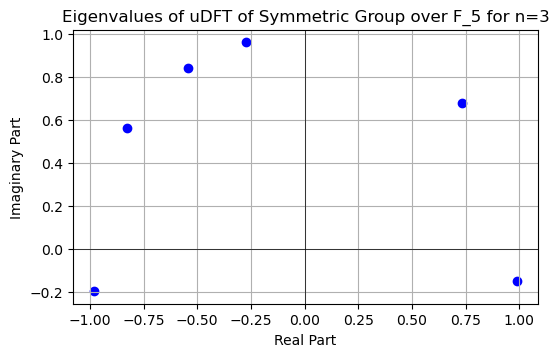

In [135]:
# Plotting the eigenvalues on the complex plane
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Eigenvalues of uDFT of Symmetric Group over F_{q} for n={n}')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()